In [2]:
import sys
# sys.path.append('/Users/bernardoloureiro/template-lib')

from utils.notebookhelpers.helpers import Helpers
from utils.dtos.templateOutputCollection import TemplateOutputCollection
from utils.dtos.variable import Metadata
from utils.dtos.templateOutput import TemplateOutput
from utils.dtos.templateOutput import OutputType
from utils.dtos.templateOutput import ChartType
import datetime
import logging
import pandas as pd
import numpy as np
from numpy import mean,std
import os
from dateutil import parser
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
import math
import scipy as scipy
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

from collections import Counter
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

##Pycaret
import jinja2
from pycaret.classification import *


In [2]:
inputDatasetParameter=Helpers.get_or_create_input_dataset(
    name="inputDataset6",
    metadata=Metadata(input_name='Model_Input_Data', is_required=True
                      , tooltip='Model Input data for Classification'),
    local_context=locals()
)


# outputDatasetParameter=Helpers.get_or_create_output_dataset(
#  name="outputDataset3",
#     metadata=Metadata(input_name='Model Accuracy Scores', is_required=True, tooltip='Dataset name to be created after the transformation'),
#     local_context=locals()
# )

outputDatasetParameter=Helpers.get_or_create_output_dataset(
 name="outputDataset3",
    metadata=Metadata(input_name='Model_Accuracy_Scores', is_required=True, tooltip='Dataset name to be created after the transformation'),
    local_context=locals()
)

outputDatasetParameter2=Helpers.get_or_create_output_dataset(
 name="outputDataset4",
    metadata=Metadata(input_name='Model_Accuracy_Scores2', is_required=True, tooltip='Dataset name to be created after the transformation'),
    local_context=locals()
)

outputDatasetParameter3=Helpers.get_or_create_output_dataset(
 name="outputDataset5",
    metadata=Metadata(input_name='Model_Accuracy_Scores3', is_required=True, tooltip='Dataset name to be created after the transformation'),
    local_context=locals()
)

In [ ]:
pd.set_option('display.max_columns',30)
label_font_dict = {'family':'sans-serif','size':13.5,'color':'brown','style':'italic'}
title_font_dict = {'family':'sans-serif','size':16.5,'color':'Blue','style':'italic'}

In [3]:
#Getting the context
contextId = 'HealtCare_Fraud_data_ML_Classification'
context = Helpers.getOrCreateContext(contextId=contextId, localVars=locals())

In [4]:
#Getting the parameters
train_iobp_df_final=inputDatasetParameter.value



outputDataset=outputDatasetParameter.value
outputDataset2=outputDatasetParameter2.value
outputDataset3=outputDatasetParameter3.value

In [5]:
train_iobp_df_final = Helpers.getEntityData(context, train_iobp_df_final)

entity doesn't exist


In [6]:
def pred_prob(clf, data): 
    """
    Description :: This function is created for storing the predicted probabability using the trained model.
    
    Input :: It accepts below input parameters :
      - clf : Trained model classifier
      - data : Dataset for which we want to generate the predictions
    """
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    """
    Description :: This function is created for calculating the AUC score on train and test data. And, plotting the ROC curve.
    
    Input :: It accepts below input parameters :
      - train_fpr : Train False +ve rate
      - train_tpr : Train True +ve rate
      - test_fpr : Test False +ve rate
      - test_tpr : Test True +ve rate
    """
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    with plt.style.context('seaborn-poster'):
      plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc), color='blue')
      plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc), color='red')
      plt.legend()
      plt.xlabel("False Positive Rate(FPR)", fontdict=label_font_dict)
      plt.ylabel("True Positive Rate(TPR)", fontdict=label_font_dict)
      plt.title("Area Under Curve", fontdict=title_font_dict)
      plt.grid(b=True, which='major', color='lightgrey', linestyle='--')
      plt.minorticks_on()
      plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    """
    Description :: This function is created for finding the best threshold value.
    """
    t = threshold[np.argmax(tpr * (1-fpr))]
    return t

def predict_with_best_t(proba, threshold):
    """
    Description :: This function is created for generating the predictions based on the best threshold value.
    """
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    """
    Description :: This function is created for plotting the confusion matrix of TRAIN and TEST sets.
    """
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    with plt.style.context('seaborn'):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='viridis')
        ax[0].set_title('Train Dataset Confusion Matrix', fontdict=title_font_dict)
        ax[0].set_xlabel("Predicted Label", fontdict=label_font_dict)
        ax[0].set_ylabel("Actual Label", fontdict=label_font_dict)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    with plt.style.context('seaborn'):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax[1], cmap='summer')
        ax[1].set_title('Test Dataset Confusion Matrix', fontdict=title_font_dict)
        ax[1].set_xlabel("Predicted Label", fontdict=label_font_dict)
        ax[1].set_ylabel("Actual Label", fontdict=label_font_dict)
    
    plt.show()
    
    return train_prediction, test_prediction

In [7]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    """
    Description :: This function is created for performing the evaluation of the trained model.
    """
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    
    # calculate tpr, fpr using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("### Train AUC = {}".format(train_auc))
    test_auc = auc(test_fpr, test_tpr)
    print("### Test AUC = {}".format(test_auc))
    
    # plotting the ROC curve
#     draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    # Best threshold value
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    # Plotting the confusion matrices
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    # Generating the F1-scores
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, train_f1_score, test_f1_score, best_t

train_iobp_df_final= pd.read_csv('C:\\Users\\binda\\Downloads\\HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS\\Health_care-project\\check.csv')

In [27]:
def RF_classifier(train_iobp_df_final):
    train_iobp_df_final = train_iobp_df_final.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
    X = train_iobp_df_final.drop(axis=1, columns=['Provider','PotentialFraud'])
    y = train_iobp_df_final['PotentialFraud']
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, stratify=y, random_state=38)
#     X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, stratify=y, random_state=39)
    
    # Standardize the data (train and test)
    robust_scaler = RobustScaler()
    robust_scaler.fit(X_train)
    X_train_std = robust_scaler.transform(X_train)
    X_test_std = robust_scaler.transform(X_test)
    
    # Standardize the data (train and test)
    robust_scaler = RobustScaler()
    robust_scaler.fit(X_train)
    X_train_std = robust_scaler.transform(X_train)
    X_test_std = robust_scaler.transform(X_test)
    
    # Performing minority oversampling
    oversample = ADASYN(sampling_strategy=0.45, n_neighbors=9)
    X_train_ovsamp, y_train_ovsamp = oversample.fit_resample(X_train_std, y_train)
    
    return X_train_ovsamp, y_train_ovsamp, X_test_std,y_test

In [28]:
X_train_ovsamp, y_train_ovsamp, X_test_std,y_test = RF_classifier(train_iobp_df_final)

X_train_ovsamp

In [19]:
rfc = RandomForestClassifier(n_estimators=70,criterion='gini',
                                   max_depth= 5,
                                   max_features='auto',
                                   min_samples_leaf=20,
                                   min_samples_split=20,
                                   random_state=45,
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0)

rfc.fit(X_train_ovsamp, y_train_ovsamp)

RandomForestClassifier(max_depth=4, max_features='auto', min_samples_leaf=30,
                       min_samples_split=30, n_estimators=70, random_state=47)

### Train AUC = 0.9463998611644271
### Test AUC = 0.9445907893541647


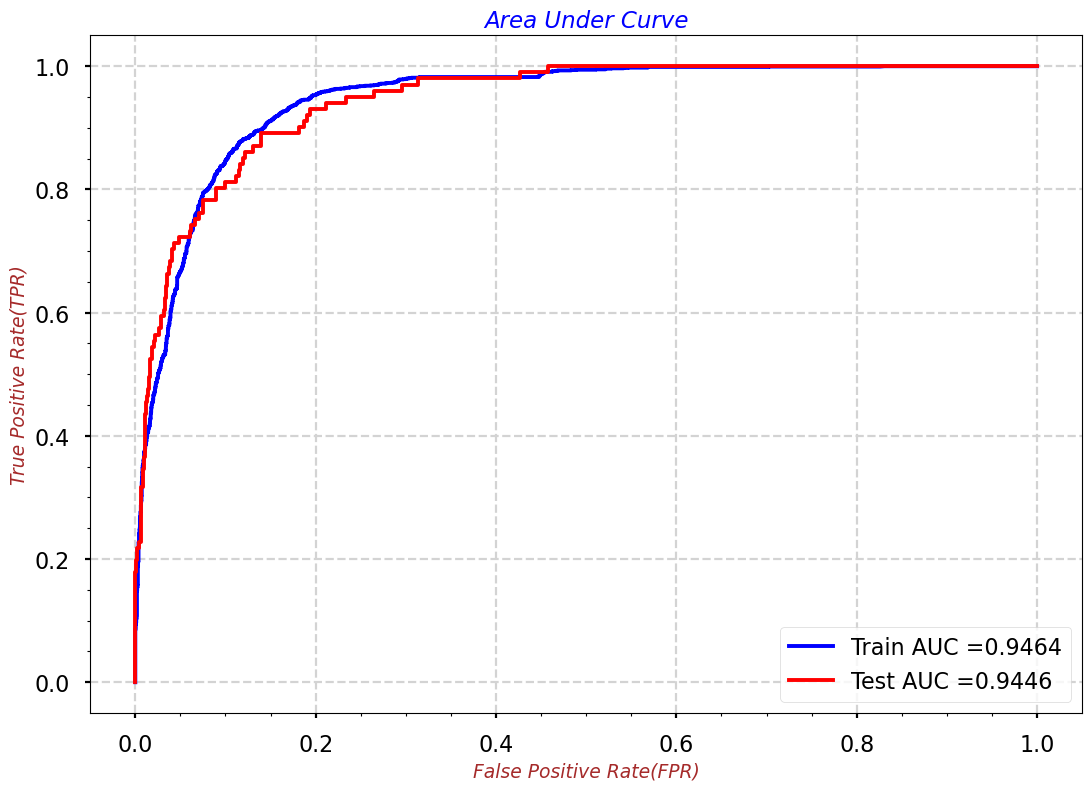

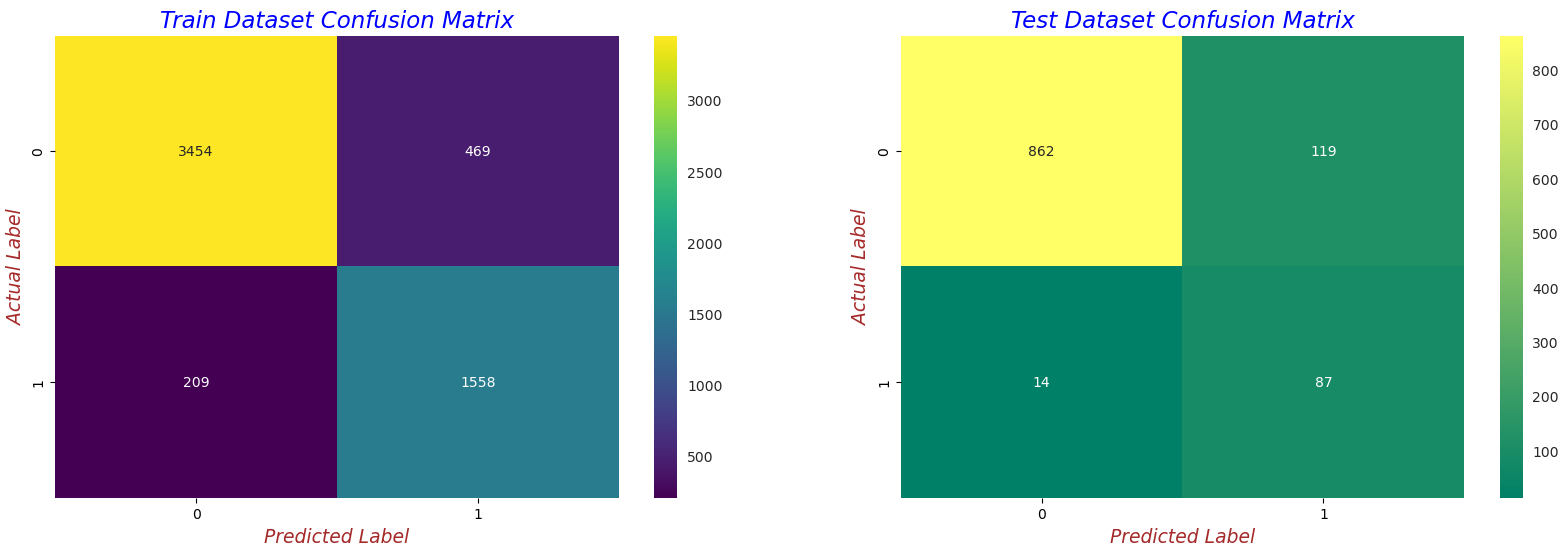



### Best Threshold = 0.4265
### Model AUC is : 0.9446
### Model Train F1 Score is : 0.8213
### Model Test F1 Score is : 0.5668


In [23]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(rfc, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

results = pd.DataFrame(zip([test_auc, train_f1_score, test_f1_score, best_t]),index=['Best Threshold','Best model AUC',
                                                                           'Model Train_F1 Score','Model Test_F1 Score'],
                                                                             columns=['Results'])

# Isolation RandomForestClassifier

In [ ]:
isolation_rfc=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.3),
                              max_features=0.7,
                              random_state=42)

# isolation_rfc.fit(data[['marks']])


In [ ]:
# isolation_rfc = RandomForestClassifier(n_estimators=70,criterion='gini',
#                                    max_depth= 5,
#                                    max_features='auto',
#                                    min_samples_leaf=20,
#                                    min_samples_split=20,
#                                    random_state=45,
#                                    min_weight_fraction_leaf=0.0,
#                                    max_leaf_nodes=None,
#                                    min_impurity_decrease=0.0,
#                                    ccp_alpha=0.0)

isolation_rfc.fit(X_train_ovsamp, y_train_ovsamp)

In [ ]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(rfc, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### isolation_rfc Best Threshold = {:.4f}".format(best_t))
print("### isolation_rfc Model AUC is : {:.4f}".format(test_auc))
print("### isolation_rfc Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### isolation_rfc Model Test F1 Score is : {:.4f}".format(test_f1_score))

results_2 = pd.DataFrame(zip([test_auc, train_f1_score, test_f1_score, best_t]),index=['Best Threshold','Best model AUC',
                                                                           'Model Train_F1 Score','Model Test_F1 Score'],
                                                                             columns=['Results'])

df = pd.concat([results,results_2])

# Pycaret

In [3]:
def pred_prob(clf, data): 
    """
    Description :: This function is created for storing the predicted probabability using the trained model.
    
    Input :: It accepts below input parameters :
      - clf : Trained model classifier
      - data : Dataset for which we want to generate the predictions
    """
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    """
    Description :: This function is created for calculating the AUC score on train and test data. And, plotting the ROC curve.
    
    Input :: It accepts below input parameters :
      - train_fpr : Train False +ve rate
      - train_tpr : Train True +ve rate
      - test_fpr : Test False +ve rate
      - test_tpr : Test True +ve rate
    """
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
#     with plt.style.context('seaborn-poster'):
#       plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc), color='blue')
#       plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc), color='red')
#       plt.legend()
#       plt.xlabel("False Positive Rate(FPR)", fontdict=label_font_dict)
#       plt.ylabel("True Positive Rate(TPR)", fontdict=label_font_dict)
#       plt.title("Area Under Curve", fontdict=title_font_dict)
#       plt.grid(b=True, which='major', color='lightgrey', linestyle='--')
#       plt.minorticks_on()
#       plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    """
    Description :: This function is created for finding the best threshold value.
    """
    t = threshold[np.argmax(tpr * (1-fpr))]
    return t

def predict_with_best_t(proba, threshold):
    """
    Description :: This function is created for generating the predictions based on the best threshold value.
    """
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def draw_confusion_matrix( y_train, y_test, y_train_pred, y_test_pred):
    """
    Description :: This function is created for plotting the confusion matrix of TRAIN and TEST sets.
    """
    fig, ax = plt.subplots(1,2, figsize=(20,6))

#     train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, y_train_pred)
#     with plt.style.context('seaborn'):
#         sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='viridis')
#         ax[0].set_title('Train Dataset Confusion Matrix', fontdict=title_font_dict)
#         ax[0].set_xlabel("Predicted Label", fontdict=label_font_dict)
#         ax[0].set_ylabel("Actual Label", fontdict=label_font_dict)

#     test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, y_test_pred)
#     with plt.style.context('seaborn'):
#         sns.heatmap(cm, annot=True, fmt='d', ax=ax[1], cmap='summer')
#         ax[1].set_title('Test Dataset Confusion Matrix', fontdict=title_font_dict)
#         ax[1].set_xlabel("Predicted Label", fontdict=label_font_dict)
#         ax[1].set_ylabel("Actual Label", fontdict=label_font_dict)
    
#     plt.show()
    
    return train_prediction, test_prediction

In [4]:
def validate_model(y_train_pred, y_test_pred,y_train,y_test):
    """
    Description :: This function is created for performing the evaluation of the trained model.
    """
#     # predict the probability of train data
#     y_train_pred = pred_prob(clf, x_train)
    
#     # predict the probability of test data
#     y_test_pred = pred_prob(clf, x_test)
    
    # calculate tpr, fpr using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("### Train AUC = {}".format(train_auc))
    test_auc = auc(test_fpr, test_tpr)
    print("### Test AUC = {}".format(test_auc))
    
    # plotting the ROC curve
#     draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    # Best threshold value
#     best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    # Plotting the confusion matrices
#     train_prediction, test_prediction = draw_confusion_matrix( y_train, y_test, y_train_pred, y_test_pred)
    
    # Generating the F1-scores
    train_f1_score = f1_score(y_train, y_train_pred)
    test_f1_score = f1_score(y_test, y_test_pred)
    
    return test_auc, train_f1_score, test_f1_score

In [ ]:
train_iobp_df_final = train_iobp_df_final.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
X = train_iobp_df_final.drop(axis=1, columns=['Provider','PotentialFraud'])
y = train_iobp_df_final['PotentialFraud']

In [ ]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, stratify=y, random_state=10)
data_train = pd.DataFrame(X_train.join(y_train))
data_test = X_test

In [ ]:
clf = setup(data = data_train, target = 'PotentialFraud',silent=True)

In [ ]:
compare_models(sort = 'F1')

In [ ]:
ada=create_model('ada')
lgm = create_model('lightgbm')

py_models_result = pd.DataFrame(clf[17][1])

In [ ]:
y_train_pred = predict_model(ada,X_train)
y_train_pred = y_train_pred['Label']

y_test_pred = predict_model(ada,X_test)
y_test_pred = y_test_pred['Label']

In [ ]:
ada_auc,train_F1,test_F1 = validate_model(y_train_pred, y_test_pred,y_train,y_test)

In [ ]:
results2 = pd.DataFrame(zip([ada_auc, train_F1, test_F1]),index=['ADA Model AUC',
                                                                           'ADA Model Train_F1 Score','ADA Model Test_F1 Score'],
                                                                             columns=['Results'])

In [ ]:
y_train_pred2 = predict_model(lgm,X_train)
y_train_pred2 = y_train_pred2['Label']

y_test_pred2 = predict_model(lgm,X_test)
y_test_pred2 = y_test_pred2['Label']

In [ ]:
lgm_auc,train2_F1,test2_F1 = validate_model(y_train_pred2, y_test_pred2,y_train,y_test)

In [ ]:
results3 = pd.DataFrame(zip([lgm_auc, train2_F1, test2_F1]),index=['LGM Model AUC',
                                                                           'LGM Model Train_F1 Score','LGM Model Test_F1 Score'],
                                                                             columns=['Results'])

result4 = pd.concat([results2,results3])

In [ ]:
outputCollection = Helpers.createOutputCollection(context)
# py_models_result = Helpers.createTemplateOutputDataset(context=context, outputName=outputDataset, dataFrame=py_models_result)
out = Helpers.createTemplateOutputDataset(context=context, outputName=outputDataset, dataFrame=results_2)
out2 = Helpers.createTemplateOutputDataset(context=context, outputName=outputDataset2, dataFrame=results2)
out3 = Helpers.createTemplateOutputDataset(context=context, outputName=outputDataset3, dataFrame=results3)

# out_chart = Helpers.createTemplateOutputPlotlibChart(context, chartTitle='LGM Model', plt=plt)
# outputCollection.addTemplateOutput(py_models_result)
outputCollection.addTemplateOutput(out)
outputCollection.addTemplateOutput(out2)
outputCollection.addTemplateOutput(out3)
# outputCollection.addTemplateOutput(out_chart)



Helpers.save(context)